### Prerequisite

* $\texttt{numpy}$ and $\texttt{matplotlib}$.

### New skills

* Probability notation and basic rules

* Likelihood functions

* Fitting a model

In [1]:
# Let's start with importing our packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# We can beautify our plots by changing the matplotlib settings a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

### Part 1: probability functions

We are now comfortable drawing random numbers using $\texttt{python}$ and have experimented with Gaussian and Poisson distributions. Before we fully apply these skills to astronomy, let's review one additional tool: probability density functions (pdf). 

PDFs tell us what values a random variable can take and how likely a certain values are. If we make a large number of draws from a random variable, the resulting histogram will closely match the PDF. 

There are two rules PDFs follow. Let's call our random variable $X$ and its PDF $p(X)$.

1. The probability that a realization of $X$ falls in the range $x_1$ to $x_2$ is:
$$p(x_1\leq X \leq x_2) = \int_{x_1}^{x_2} dX \cdot p(X)$$

2. All PDFs must integrate to 1:
$$\int dX \cdot p(X)=1$$

In the last notebook, we saw examples of PDFs, such as:

**Gaussian**: $p(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$
        
**Poisson**: $P(X=k) = \dfrac{\lambda^k e^{-\lambda}}{k!}$

Let's now revisit Gaussian distributions using this new knowledge. First, we'll write a function for a gaussian PDF.

In [2]:
def gaussian_pdf(x, mu, sigma):
    return np.exp( -np.power(x-mu,2) / (2*sigma**2) ) / np.sqrt(2*np.pi*sigma)

Great! Now we can compare our function with a histogram of random draws. 

What happens when we set $\texttt{density=True}$ vs. $\texttt{density=False}$ for $\texttt{plt.hist}$?

What happens as the number of draws increases (try 10, 100, 1000, 10000)?

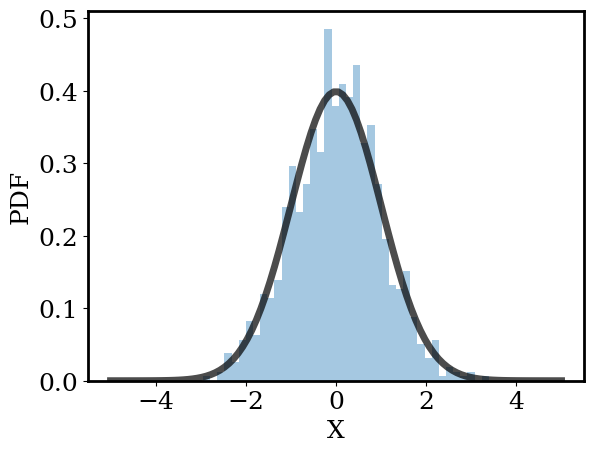

In [3]:
# parameters of our Gaussian distribution
mu = 0; sigma = 1

# evaluate the PDF on a x-grid
x = np.linspace(-5,5,100)
y = gaussian_pdf(x, mu, sigma)

# plot the PDF
plt.plot(x,y,alpha=0.7,color='k',linewidth=5) 

# draw random values using numpy
rand = np.random.normal(loc = mu, scale = sigma, size = 1000)

# plot the histogram
plt.hist(rand,density=True,alpha=0.4,bins=40)

# it's always good practice to label the axes (even if it's a bit arbitrary in our case)
_ = plt.xlabel('X')
_ = plt.ylabel('PDF')

# Part 2: fitting models to data

### Part 2.1: why fit a model?

You may rightly be asking, what does any of this have to do with astronomy? Everything (or at least a lot of things)! For us, there are two broad applications of PDFs. 

1. Understanding the signal-to-noise properties of astronomical images.

2. Learning from observations by fitting models to data.

In the last notebook, we focused on the first application, here we'll focus on the second.

Let's revist the Gaia data as an example dataset.  

In [4]:
# path to the table
path = 'data/gaia_100pc.csv'

# loading the table; this function assumes a 'comma separated file (aka csv)'
gaia = pd.read_csv(path)

# behind the scenes cleaning (likely want to distribute this shortened version)
gaia.loc[:,'radius'] = gaia.radius_gspphot
gaia.loc[:,'teff']   = gaia.teff_gspphot
gaia.loc[:,'gmag']   = gaia.phot_g_mean_mag
gaia.loc[:,'rmag']   = gaia.phot_rp_mean_mag
gaia.loc[:,'bmag']   = gaia.phot_bp_mean_mag
gaia.loc[:,'distance']   = gaia.distance_gspphot

# gaia = gaia[['radius','teff','distance','gmag','rmag','bmag','ecl_lon','ecl_lat']]

# simple errors
gaia.loc[:,'color']     = gaia.gmag - gaia.rmag
gaia.loc[:,'color_err'] = 0.04
gaia.loc[:,'teff_err']  = 10. # K

In [5]:
gaia.columns

Index(['source_id', 'radius_gspphot', 'radius_gspphot_lower',
       'radius_gspphot_upper', 'teff_gspphot', 'teff_gspphot_lower',
       'teff_gspphot_upper', 'logg_gspphot', 'logg_gspphot_lower',
       'logg_gspphot_upper', 'fem_gspspec', 'fem_gspspec_lower',
       'fem_gspspec_upper', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'distance_gspphot', 'distance_gspphot_lower',
       'distance_gspphot_upper', 'ecl_lon', 'ecl_lat', 'radius', 'teff',
       'gmag', 'rmag', 'bmag', 'distance', 'color', 'color_err', 'teff_err'],
      dtype='object')

Earlier we saw a strong correlation between the color and temperature of a star. Let's take another look.

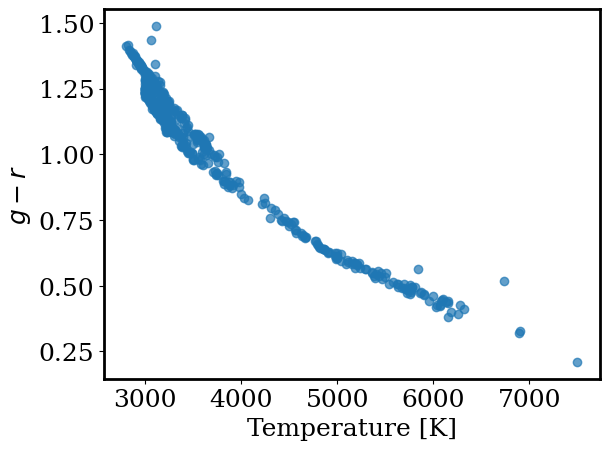

In [6]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

We have a clear observational result: color and temperature of a star are strongly correlated. 

However, we still don't know *how* color and temperature are related. Is the relation linear, quadratic, or perhaps much more complex? Answering this question will greatly increase our understanding of the stars in our catalog (it will also help our theorist friends try to *explain* what's happening here). 

### Part 2.2: how to fit a model

From the plot above, it's reasonible to *first* assume the relation between color and temperature is linear:
$$ g-r = m \times T + b,$$
where $m$ and $b$ are coefficients we want to learn. 

First, let's trying finding the coefficients $m$ and $b$ by hand. 

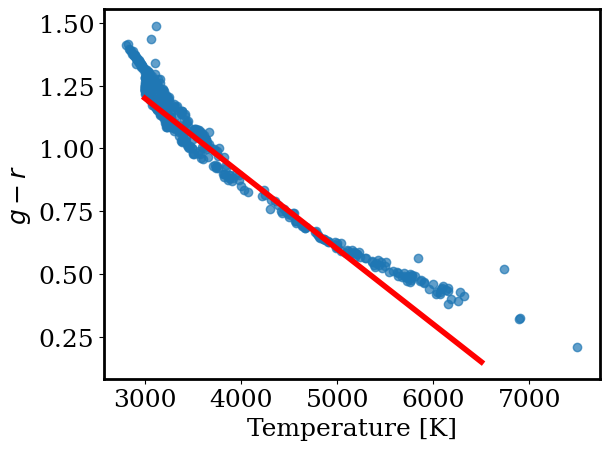

In [7]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
m = -3e-4; b = 2.1
x = np.linspace(3000,6500, 10)
plt.plot(x, m * x + b,color='r',linewidth=4)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

What if we want a more robust approach?

For simplicity, let's imagine we have only one data point, a single star of temperature $5000 \pm 10 K$ and color $g-r=0.6 \pm 0.2$.

We can now ask, for a given set of values of $m,b$ how *likely* were we to have observed $g-r=0.6$ given that the star's temperature is $5000$ K? Thankfully, we just learned about PDFs! Assuming the uncertainties are well described by a Gaussian function (this is typically true, except for a few special cases we will discuss) the likelihood of measuring $g-r=0.6$ is:
$$ \ln p(g-r=0.6 \mid b, m, T = 5000) = - \frac{1}{2} \Big ( \frac{ [0.6 - (m\times5000K+b)]^2 }{0.2^2+(m\times10K)^2} + \ln (2 \pi [0.2^2+(m\times10K)^2]) \Big ) $$ 
notice we took the natural log to undo the exponential. This is an example of a likelihood function.

Of course, one data point is certainly not enough to fit our model with. How does the likelihood function work with multiple datapoints? Assuming each datapoint is independent we simply consider the product of each datapoint's likelihood function. In our case, 'independent' means that the measurements for one star do not dependent on the measurements for the others, which is usually a safe assumption. If we consider a second star with $g-r=1.25 \pm 0.3$ given that the star's temperature is $3000 \pm 50$ K, the likelihood of observing both stars is then:
$$ \ln p(g-r= \{0.6, 1.125 \} \mid b, m, T = \{ 5000, 3000 \}) \propto - \frac{1}{2} \Big ( \frac{ [0.6 - (m\times5000k+b)]^2 }{ 0.2^2+(m\times10K)^2 } + \ln (2 \pi [0.2^2+(m\times10K)^2]) \Big ) - \frac{1}{2} \Big ( \frac{ [1.25 - (m\times3000k+b)]^2 }{0.3^2+(m\times30K)^2}  + \ln (2 \pi [0.3^2+(m\times30K)^2]) \Big ). $$

We are now ready to write our generalized likelihood function for a sample of $N$ measurements (indexed by $i=1,\dots,N$):
$$ \ln p( g-r \mid b, m, T) \propto - \frac{1}{2} \sum \Big ( \frac{ [ (g-r)_i - (m\times T_i +b)]^2 }{ \sigma_{(g-r)_i} ^2 +(m\times \sigma_T~K)^2 } + \ln (2 \pi [\sigma_{(g-r)_i}^2+(m\times \sigma_T~K)^2])  \Big ). $$

It's important to remember our three key assumptions (all of which are reasonable in this case):

1. Measurement uncertainties are Gaussian
2. Measurements are independent of each other

[Note, this is my hand-wavy explanation of the likelihood function, while trying to side step Bayes. Definetely feel free to interate on this or we can simply introduce the likelihood funciton as a black box]

### Part 2.3: fitting a model with python

Let's now write the likelihood function in python. 

We want to find the set of coefficients that *maximimize* the likelihood function for our Gaia dataset. To do so, we will use the $\texttt{scipy.optimize.differential_evolution}$ function. This tool finds the combination of parameters that *minimizes* the input function. 

Since we want to maximimize and the tool we have minimizes, we first have to make sure our function is equal to negative the likelihood function.

In [8]:
def linear(theta, T, T_error = 0):
    m,b = theta
    
    model = T * m + b
    model_error = T_error * m
    
    return model, model_error

def minus_log_likelihood_function(theta, func, g_r, g_r_error, T, T_error):
    model, model_error = func(theta, T, T_error)
    
    error2 = g_r_error**2 + model_error**2
    
    return np.sum( (np.power(g_r-model,2) / error2) + np.log(2 * np.pi * error2) )
#     return np.sum( (np.power(g_r-model,2) / error2) )

In [9]:
import scipy

out = scipy.optimize.differential_evolution(minus_log_likelihood_function, [(-1,0),(0,10)],
                        args=(linear, gaia.color, gaia.color_err, 
                                             gaia.teff,  gaia.teff_err) )

In [10]:
out

 message: Optimization terminated successfully.
 success: True
     fun: -980.3110794998786
       x: [-2.803e-04  2.067e+00]
     nit: 38
    nfev: 1227

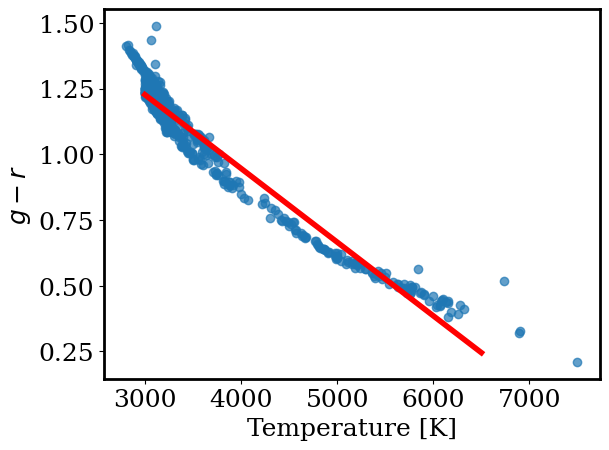

In [11]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
m,b = out.x
x = np.linspace(3000, 6500, 10)
plt.plot(x, m * x + b,color='r',linewidth=4)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

The linear model works okay but not great. Let's also try a model where color is *inversely* proportional to temperature:
$$ g-r = b / T + c $$

In [12]:
def inverse(theta, T, T_error = 0):
    m,b = theta
    
    model = (m / T) + b
    model_error = (T_error/T) * m / T
    
    return model, model_error

In [13]:
out_inverse = scipy.optimize.differential_evolution(minus_log_likelihood_function, [(1e3,1e4),(-10,10)],
                        args=(inverse, gaia.color, gaia.color_err, 
                                             gaia.teff,  gaia.teff_err) )

In [14]:
out_inverse

 message: Optimization terminated successfully.
 success: True
     fun: -1822.9761214744683
       x: [ 4.932e+03 -3.696e-01]
     nit: 20
    nfev: 699
     jac: [-1.592e-04 -3.321e-01]

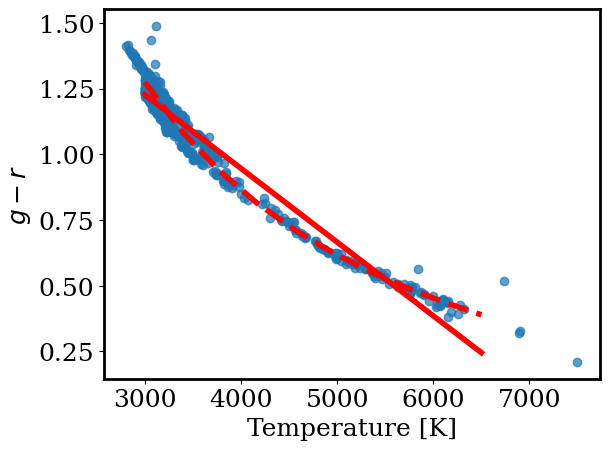

In [15]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
x = np.linspace(3000, 6500, 10)

# linear fit
m,b = out.x
plt.plot(x, m*x+b,color='r',linewidth=4)

m,b = out_inverse.x
plt.plot(x, m/x+b,color='r',linewidth=4,linestyle='--')

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

### Part 2.4: comparing model fits

The inverse model certainly *looks* better than the linear model. How can we ask that question quantitatively?

In [16]:
def chi2(theta, func, g_r, g_r_error, T, T_error):
    model, model_error = func(theta, T, T_error)
    
    error2 = g_r_error**2 + model_error**2
    
    return np.sum( (np.power(g_r-model,2) / error2))

In [17]:
chi2_lin = chi2(out.x, linear, gaia.color, gaia.color_err, gaia.teff,  gaia.teff_err)
chi2_inv = chi2(out_inverse.x, inverse, gaia.color, gaia.color_err, gaia.teff,  gaia.teff_err)

r_chi2_lin = chi2_lin / (len(gaia) - 2)
r_chi2_inv = chi2_inv / (len(gaia) - 2)

print('Linear model reduced chi^2: {:.2}'.format(r_chi2_lin))
print('Inverse model reduced chi^2: {:.2}'.format(r_chi2_inv))

Linear model reduced chi^2: 2.7
Inverse model reduced chi^2: 0.99


In terms of reduced $\chi^2$, the $g-r \propto T^{-1}$ model is favored over $g-r \propto T$. So what? Well, we've just rediscovered Wein's law. (insert blurb on Wein's law here and how color is a proxy for $\lambda_\mathrm{max}$)

$$ \lambda_\mathrm{max} \propto 1 / T $$ 

### Resources

* [General overview of statistics rules](https://machinelearningmastery.com/bayes-theorem-for-machine-learning/)
* [Qualitative introduction to Bayes' Theorem](https://towardsdatascience.com/intro-to-bayesian-statistics-5056b43d248d)
* [Penn State STAT 414](https://online.stat.psu.edu/stat414/book), wonderful mid-high level introduction to statstics 

### Textbooks (available online)
* Higher level textbook (Modern Mathematical Statistics with Applications, 2nd ed)
* Introductory level textbook (OpenIntro Statistics 4th edition)